# End-to-End Regression Project using Indian Rental Data

## 📘 Regression: Problem Overview

### What is Regression?

**Regression** is a machine learning task where we predict a **continuous numeric value** from input features.

Common regression problems include:

* 🏠 House price / rental prediction
* 💼 Salary prediction
* 📈 Sales or demand estimation
* ⚡ Energy or cost estimation

All of these involve predicting a **numeric value**, not a category.

### Type of Learning: Supervised

This is a **supervised learning** problem.

* We are given **input features (X)**
* We are given the **correct output (y)**
* The model learns the relationship between them from **labeled training data**

In this notebook:

* **Inputs:** house attributes (area, city, bedrooms, furnishing, etc.)
* **Target:** monthly rent

### Dataset Used

* Based on a **MagicBricks rental listings dataset (India)** [Kaggle Dataset Link](https://www.kaggle.com/datasets/pranayjagtap06/indian-rental-housing-price-dataset)
* Slightly **modified for teaching purposes**

  * to demonstrate preprocessing
  * to handle missing values
  * to build clean end-to-end pipelines

### What We’ll Do in This Notebook

We will walk through a **complete regression workflow**:

1. Understand and explore the data
2. Prepare features and handle missing values
3. Split data into train / validation / test
4. Build and compare regression models
5. Evaluate on unseen test data

The goal is to understand **how regression is applied end to end in practice**, not just to train a model.


## 0) Setup

* Detailed setup instructions are available in the **README** of the repository
* **Download the dataset** and place it inside the `data/` folder
* This project uses **uv** for environment and dependency management
* Clone the repo and follow the README — all required libraries (pandas, scikit-learn, matplotlib, etc.) will be installed automatically
Once setup is complete, you’re ready to run this notebook end to end.


## 1) Load the dataset

We start by loading the CSV into a DataFrame.
Then we preview a few rows to understand the columns.

In [1]:
# Pandas is the standard library for working with tables in Python.
import pandas as pd

DATA_PATH = r"data\cities_magicbricks_rental_prices.csv"
df = pd.read_csv(DATA_PATH)

df.head(5)






,house_type,locality,city,area,beds,bathrooms,balconies,furnishing,area_rate,rent
0,"2 BHK Flat for Rent in Oberoi Woods, Goregaon ...",Goregaon East,Mumbai,897.0,2.0,2.0,0.0,Semi-Furnished,134.0,120000.0
1,"1 BHK Flat for Rent in Sapphire Lakeside, Powa...",Powai,Mumbai,490.0,1.0,1.0,0.0,Semi-Furnished,82.0,40000.0
2,1 BHK House for Rent in Mundhwa Pune,Mundhwa,Pune,550.0,1.0,1.0,0.0,Unfurnished,22.0,12000.0
3,"2 BHK Flat for Rent in Hingna, Nagpur",Hingna,Nagpur,1000.0,2.0,2.0,0.0,Unfurnished,8.0,8000.0
4,1 BHK Flat for Rent in Unique Star Harsh Vihar...,Mira Road,Mumbai,595.0,1.0,1.0,0.0,Unfurnished,25.0,15000.0


### Dataset Overview & Feature Description

Each row in the dataset represents a **single rental property listing**.
Below is a brief description of the available features:

| Feature        | Description                                           |
| -------------- | ----------------------------------------------------- |
| **house_type** | Title or type of the property                         |
| **locality**   | Locality or neighborhood of the property              |
| **city**       | City where the property is located                    |
| **area**       | Property area in square feet (sq ft)                  |
| **beds**       | Number of bedrooms                                    |
| **bathrooms**  | Number of bathrooms                                   |
| **balconies**  | Number of balconies                                   |
| **furnishing** | Furnishing status of the property                     |
| **area_rate**  | Area rate in Indian Rupees (₹) per sq ft              |
| **rent**       | Monthly rent in Indian Rupees (₹) *(target variable)* |


> **Notes**
> - `rent` is the target we want to predict. It is continuous → **regression**.
> - We have numeric features (`area`, `beds`, …) and categorical features (`city`, `furnishing`, …).
> - `house_type` is free text. We will skip it in the first baseline model.

## 2) Quick data checks

We check size, data types, and missing values.
This tells us what preprocessing we need.

In [2]:
# Quick dataset size summary (readable format)
from IPython.display import display, Markdown

rows, cols = df.shape
display(Markdown(f"**Dataset size:** `{rows:,}` rows × `{cols:,}` columns"))


**Dataset size:** `7,694` rows × `10` columns

> **Notes**
> - More rows usually means more stable model estimates.
> - A small dataset can make model comparisons noisy.

In [3]:
# Basic schema overview
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7694 entries, 0 to 7693
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   house_type  7694 non-null   str    
 1   locality    7543 non-null   str    
 2   city        7547 non-null   str    
 3   area        7549 non-null   float64
 4   beds        7548 non-null   float64
 5   bathrooms   7519 non-null   float64
 6   balconies   7535 non-null   float64
 7   furnishing  7538 non-null   str    
 8   area_rate   7541 non-null   float64
 9   rent        7694 non-null   float64
dtypes: float64(6), str(4)
memory usage: 1.2 MB


> **Notes**
> - Categorical columns typically show up as `object`.
> - Numeric columns show up as `int64` or `float64`.


### Inspecting for Missing Values

You should see a **small amount of missing values**.
We injected them on purpose so we can demonstrate missing-value handling.

In [4]:
# Rich schema summary (types + missingness)
from IPython.display import display
import pandas as pd

schema = pd.DataFrame({
    "column": df.columns,
    "dtype": [str(t) for t in df.dtypes],
    "missing": df.isna().sum().values,
    "missing_%": (df.isna().mean() * 100).round(2).values,
})
schema = schema.sort_values(["missing", "column"], ascending=[False, True]).reset_index(drop=True)

display(
    schema.style
        .format({"missing": "{:,}", "missing_%": "{:.2f}%"})
        .bar(subset=["missing_%"], align="mid")
        .set_caption("Schema summary (sorted by missingness)")
)


,column,dtype,missing,missing_%
0,bathrooms,float64,175,2.27%
1,balconies,float64,159,2.07%
2,furnishing,str,156,2.03%
3,area_rate,float64,153,1.99%
4,locality,str,151,1.96%
5,city,str,147,1.91%
6,beds,float64,146,1.90%
7,area,float64,145,1.88%
8,house_type,str,0,0.00%
9,rent,float64,0,0.00%


> **Notes**
> - Missing values are scattered.
> - This is common in real data pipelines.

## 3) Handling missing data

Missing data is normal in real projects.

Common strategies:
1. **Drop** rows or columns (fast, but you may lose signal)  
2. **Impute** (replace with best guess) missing values (simple and effective for baselines)  
3. **Model-based imputation** (KNN, MICE, etc. — more complex)

In this notebook:
- For **numeric** columns, we will impute using the **mean**.
- For **categorical** columns, we will impute using the **most frequent** category.

In [5]:
# Missingness percentage (top)
import pandas as pd
from IPython.display import display

missing_pct = (df.isna().mean() * 100).sort_values(ascending=False).reset_index()
missing_pct.columns = ["column", "missing_%"]

display(
    missing_pct.head(12).style
        .format({"missing_%": "{:.2f}%"})
        .bar(subset=["missing_%"], align="mid")
        .set_caption("Missingness percentage (top columns)")
)


,column,missing_%
0,bathrooms,2.27%
1,balconies,2.07%
2,furnishing,2.03%
3,area_rate,1.99%
4,locality,1.96%
5,city,1.91%
6,beds,1.90%
7,area,1.88%
8,house_type,0.00%
9,rent,0.00%


> **Notes**
> - If missingness is very high in a column (say 40%+), consider dropping it or collecting better data.
> - Here, missingness is intentionally small. This makes imputation a reasonable choice.

### 3.1 Simple imputation demo (before pipelines)

We will demonstrate imputation on a small subset.
Later, we will do this properly inside a pipeline.

In [6]:
# SimpleImputer is scikit-learn's standard tool for filling missing values.
from sklearn.impute import SimpleImputer
from IPython.display import display

numeric_cols = ["area", "beds", "bathrooms", "balconies", "area_rate"]
numeric_cols = [c for c in numeric_cols if c in df.columns]

cat_cols = ["city", "furnishing"]
cat_cols = [c for c in cat_cols if c in df.columns]

num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")

df_num_demo = pd.DataFrame(num_imputer.fit_transform(df[numeric_cols]), columns=numeric_cols)
df_cat_demo = pd.DataFrame(cat_imputer.fit_transform(df[cat_cols]), columns=cat_cols)

missing_before_after = pd.DataFrame(
    {
        "before_imputation": [int(df[numeric_cols].isna().sum().sum()), int(df[cat_cols].isna().sum().sum())],
        "after_imputation":  [int(df_num_demo.isna().sum().sum()), int(df_cat_demo.isna().sum().sum())],
    },
    index=["numeric (total)", "categorical (total)"]
)
display(missing_before_after)


,before_imputation,after_imputation
numeric (total),778,0
categorical (total),303,0


> **Notes**
> - After imputation, the demo subsets contain **no missing values**.
> - This is exactly what we want before training most models.
> - We will do the same thing again inside a pipeline (the safer approach).
>   
>  **Questions**
> - What is the problem with the approach of missing values?
> - What would you do if the target column has a missing value?

### Demo: Full rows before vs after

In [7]:

# Choose one numeric and one categorical column to demonstrate
demo_numeric_col = "beds"
demo_categorical_col = "furnishing"

# Get indices where these columns have missing values
num_missing_idx = df[df[demo_numeric_col].isna()].head(5).index
cat_missing_idx = df[df[demo_categorical_col].isna()].head(5).index

# Combine indices (avoid duplicates)
demo_idx = num_missing_idx.union(cat_missing_idx)

# BEFORE imputation (original dataframe)
print("Rows BEFORE imputation")
display(df.loc[demo_idx])

# AFTER imputation (reconstructed dataframe)
df_after_demo = df.copy()
df_after_demo.loc[:, numeric_cols] = df_num_demo
df_after_demo.loc[:, cat_cols] = df_cat_demo

print("Rows AFTER imputation")
display(df_after_demo.loc[demo_idx])


Rows BEFORE imputation


,house_type,locality,city,area,beds,bathrooms,balconies,furnishing,area_rate,rent
58,1 BHK House for Rent in Manjari BK Pune,Manjri Budruk,Pune,630.0,1.0,1.0,0.0,NaN,12.000000,7500.0
74,3 BHK House for Rent in Block C Dashrath Puri ...,Block C Dashrath Puri,New Delhi,900.0,NaN,2.0,2.0,Semi-Furnished,22.222222,20000.0
123,"4 BHK Flat for Rent in Block 1st Koramangala, ...",Block 1st Koramangala,Bangalore,2100.0,4.0,4.0,3.0,NaN,71.000000,150000.0
175,"4 BHK Flat for Rent in Bandra West, Mumbai",Bandra West,NaN,2000.0,NaN,5.0,2.0,Semi-Furnished,250.000000,500000.0
197,3 BHK Flat for Rent in Kolte Patil IVY Apartme...,Wagholi,Pune,1300.0,3.0,3.0,NaN,NaN,25.000000,33000.0
209,1 BHK House for Rent in Hinjawadi Pune,Hinjewadi,Pune,650.0,1.0,NaN,2.0,NaN,18.000000,12000.0
210,1 BHK House for Rent in Jogeshwari East Mumbai,Jogeshwari East,Mumbai,350.0,1.0,1.0,0.0,NaN,34.000000,12000.0
237,"2 BHK House for Rent in The Empyrean, Kotewada...",Kotewada,Nagpur,1100.0,NaN,2.0,0.0,Unfurnished,8.000000,8458.0
282,2 BHK House for Rent in Sunkadakatte Bangalore,Sunkadakatte,Bangalore,600.0,NaN,1.0,0.0,Semi-Furnished,15.000000,9000.0
323,"4 BHK Flat for Rent in Jeevan Niketan, New Delhi",Jeevan Niketan,New Delhi,1800.0,NaN,3.0,0.0,Unfurnished,25.000000,45000.0


Rows AFTER imputation


,house_type,locality,city,area,beds,bathrooms,balconies,furnishing,area_rate,rent
58,1 BHK House for Rent in Manjari BK Pune,Manjri Budruk,Pune,630.0,1.000000,1.000000,0.000000,Semi-Furnished,12.000000,7500.0
74,3 BHK House for Rent in Block C Dashrath Puri ...,Block C Dashrath Puri,New Delhi,900.0,2.206545,2.000000,2.000000,Semi-Furnished,22.222222,20000.0
123,"4 BHK Flat for Rent in Block 1st Koramangala, ...",Block 1st Koramangala,Bangalore,2100.0,4.000000,4.000000,3.000000,Semi-Furnished,71.000000,150000.0
175,"4 BHK Flat for Rent in Bandra West, Mumbai",Bandra West,New Delhi,2000.0,2.206545,5.000000,2.000000,Semi-Furnished,250.000000,500000.0
197,3 BHK Flat for Rent in Kolte Patil IVY Apartme...,Wagholi,Pune,1300.0,3.000000,3.000000,0.814333,Semi-Furnished,25.000000,33000.0
209,1 BHK House for Rent in Hinjawadi Pune,Hinjewadi,Pune,650.0,1.000000,2.136188,2.000000,Semi-Furnished,18.000000,12000.0
210,1 BHK House for Rent in Jogeshwari East Mumbai,Jogeshwari East,Mumbai,350.0,1.000000,1.000000,0.000000,Semi-Furnished,34.000000,12000.0
237,"2 BHK House for Rent in The Empyrean, Kotewada...",Kotewada,Nagpur,1100.0,2.206545,2.000000,0.000000,Unfurnished,8.000000,8458.0
282,2 BHK House for Rent in Sunkadakatte Bangalore,Sunkadakatte,Bangalore,600.0,2.206545,1.000000,0.000000,Semi-Furnished,15.000000,9000.0
323,"4 BHK Flat for Rent in Jeevan Niketan, New Delhi",Jeevan Niketan,New Delhi,1800.0,2.206545,3.000000,0.000000,Unfurnished,25.000000,45000.0


## 4) Summary statistics

We inspect numeric summaries to spot outliers and scale differences.

In [8]:
# Summary statistics (styled)
import pandas as pd
from IPython.display import display

summary = df.describe(include="all").transpose()
# Show a compact view first (top rows) then let user scroll in output if needed
display(
    summary.style
        .set_caption("Summary statistics (all columns)")
)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
house_type,7694,5469,"3 BHK Flat for Rent in Whitefield, Bangalore",29,nan,nan,nan,nan,nan,nan,nan
locality,7543,1963,Hadapsar,105,nan,nan,nan,nan,nan,nan,nan
city,7547,5,New Delhi,1774,nan,nan,nan,nan,nan,nan,nan
area,7549.000000,nan,nan,nan,1104.767519,1200.557664,2.000000,600.000000,900.000000,1300.000000,70000.000000
beds,7548.000000,nan,nan,nan,2.206545,0.993219,1.000000,1.000000,2.000000,3.000000,10.000000
bathrooms,7519.000000,nan,nan,nan,2.136188,1.030174,0.000000,1.000000,2.000000,3.000000,10.000000
balconies,7535.000000,nan,nan,nan,0.814333,1.238338,0.000000,0.000000,0.000000,2.000000,10.000000
furnishing,7538,3,Semi-Furnished,3349,nan,nan,nan,nan,nan,nan,nan
area_rate,7541.000000,nan,nan,nan,47.646552,69.415843,2.000000,21.000000,31.444444,54.000000,2586.000000
rent,7694.000000,nan,nan,nan,54791.523525,97403.296215,1000.000000,15000.000000,28000.000000,57000.000000,2700000.000000


> **Note**
> - Rent often has a long right tail (premium listings).
> - Outliers can dominate RMSE.
> - Category counts can be unbalanced (some cities have far more listings).

## 5) Split data into train / validation / test

We use three splits:
- **train** (60%) : fit the model  
- **validation** (20%): compare models / choices  
- **test** (20%) : final unbiased evaluation  

We keep the test set untouched until the end.

In [9]:
# train_test_split gives a reproducible split.
from sklearn.model_selection import train_test_split
from IPython.display import display

X = df.drop(columns=["rent"])
y = df["rent"]

# 20% test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# From remaining 80%, take 25% as validation -> 20% overall
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42
)

split_sizes = pd.DataFrame(
    {
        "rows": [len(X_train), len(X_val), len(X_test)],
        "share": [len(X_train)/len(df), len(X_val)/len(df), len(X_test)/len(df)],
    },
    index=["train", "validation", "test"]
)
split_sizes["share"] = (split_sizes["share"] * 100).round(1).astype(str) + "%"
display(split_sizes)


,rows,share
train,4616,60.0%
validation,1539,20.0%
test,1539,20.0%


> **Notes**
> - This is a safe pattern: we do not tune on the test set.
> - Validation is where we compare models.
> - We might want to do different split options

## 6) Exploratory Data Analysis (EDA)

EDA builds intuition.
We ask:
- What does rent look like?
- Which numeric features move rent?
- How do cities and furnishing levels differ?

We will use **Seaborn** for cleaner, more “report-like” visuals.

In [10]:
# Seaborn sits on top of Matplotlib and gives nicer default plots.
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid")

def format_inr(x, pos=None):
    try:
        return "₹ {:,}".format(int(x))
    except Exception:
        return str(x)

inr_formatter = FuncFormatter(format_inr)

### 6.1 Distribution of rent (histogram + box)

- histogram for shape
- boxplot for outliers

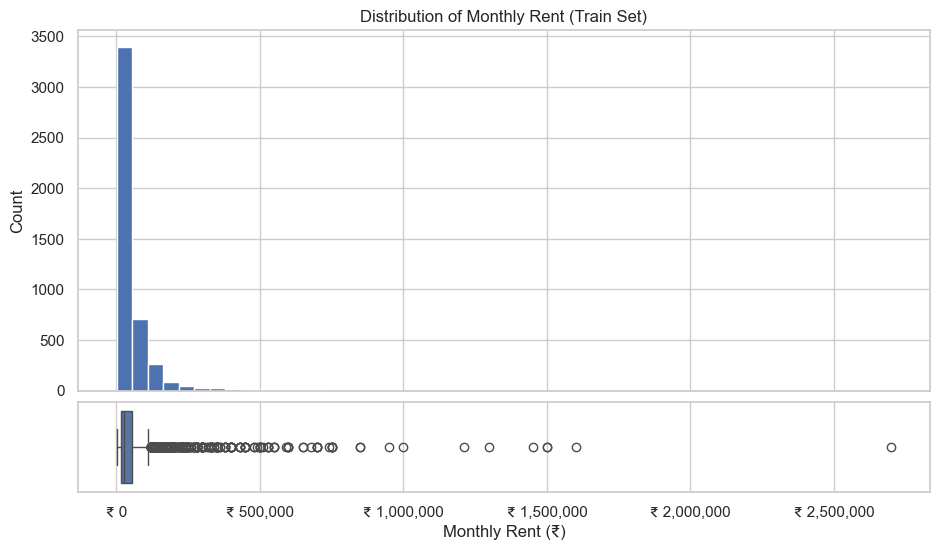

In [11]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(11, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0.05)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Matplotlib histogram (avoids seaborn/pandas option incompatibilities)
ax1.hist(y_train, bins=50)
ax1.set_title("Distribution of Monthly Rent (Train Set)")
ax1.set_xlabel("")
ax1.set_ylabel("Count")
ax1.xaxis.set_major_formatter(inr_formatter)

sns.boxplot(x=y_train, ax=ax2)
ax2.set_xlabel("Monthly Rent (₹)")
ax2.xaxis.set_major_formatter(inr_formatter)

plt.show()


> **Inference**
> - The distribution is right-skewed. A few premium rentals exist.
> - The boxplot makes outliers obvious.
> - RMSE will be sensitive to extreme rents.

### 6.2 Numeric features vs rent

We plot rent against each numeric feature.
We also add a trend line to make the direction clearer.

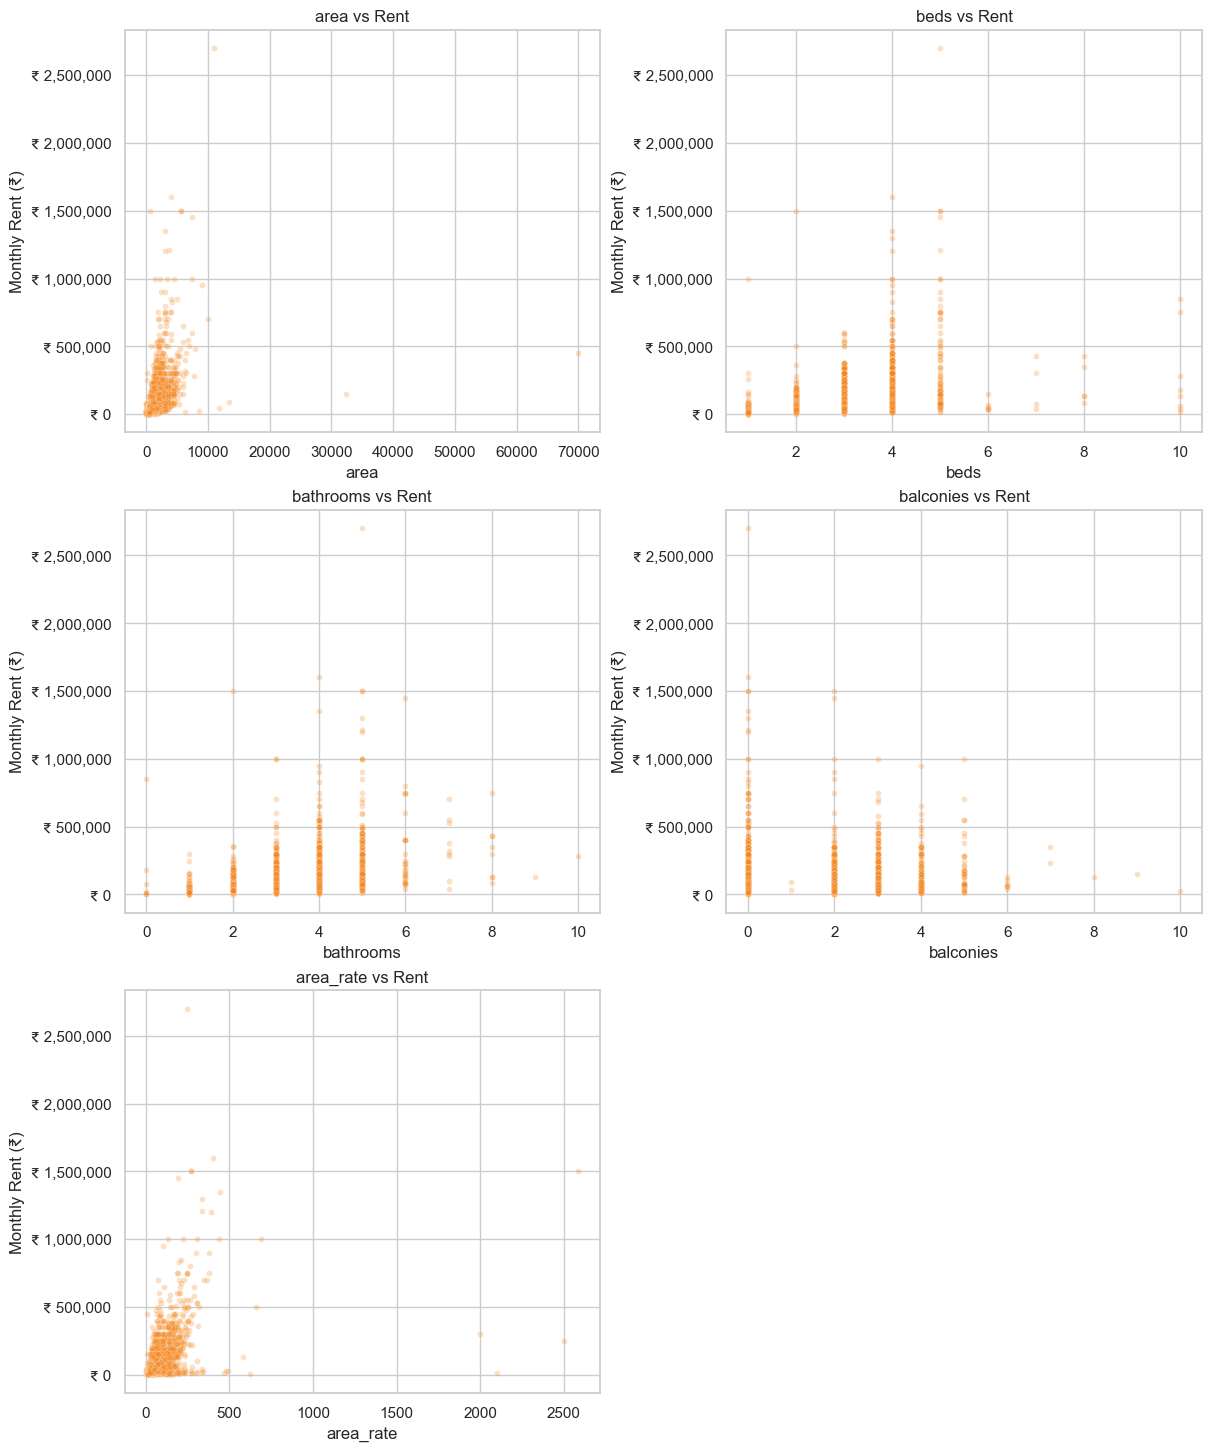

In [12]:
# %matplotlib widget

import numpy as np

numeric_cols = ["area", "beds", "bathrooms", "balconies", "area_rate"]
numeric_cols = [c for c in numeric_cols if c in df.columns]

# Plot in a grid to reduce scrolling
n = len(numeric_cols)
ncols = 2 if n > 1 else 1
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(12, 4.8 * nrows),
    constrained_layout=True
)

axes = np.atleast_1d(axes).ravel()

for ax, col in zip(axes, numeric_cols):
    sns.scatterplot(
        data=df,
        x=col,
        y="rent",
        alpha=0.25,
        s=18,
        color="#F58518",
        ax=ax
    )
    ax.yaxis.set_major_formatter(inr_formatter)
    ax.set_title(f"{col} vs Rent")
    ax.set_xlabel(col)
    ax.set_ylabel("Monthly Rent (₹)")

# Hide unused axes
for ax in axes[len(numeric_cols):]:
    ax.set_visible(False)

plt.show()


> **Notes**
> - `area` typically shows the clearest upward trend.
> - Discrete counts (`beds`, `bathrooms`) create “bands”.

### 6.2.1 A 3D view (rent vs area vs area_rate)

A 3D scatter can be a fun way to see how **two** inputs relate to rent at the same time.
Use it for intuition, not for precise conclusions.

In [13]:
import plotly
import plotly.io as pio

print("Plotly version:", plotly.__version__)
print("Available renderers:", pio.renderers)

# Best defaults for JupyterLab:
# Try one of these (first one usually works)
#pio.renderers.default = "notebook_connected"   # good for JupyterLab + classic
#pio.renderers.default = "jupyterlab"         # works in some setups
pio.renderers.default = "iframe"             # always works, slightly heavier


Plotly version: 6.5.2
Available renderers: Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']



In [14]:
import plotly.express as px

# Prepare clean data for 3D visualization
cols3d = ["area", "area_rate", "rent"]
df3d = df[cols3d + ["city"]].dropna().copy()

fig = px.scatter_3d(
    df3d,
    x="area",
    y="area_rate",
    z="rent",
    color="city",                     # remove this line if you want single-color points
    opacity=0.5,
    title="3D View: Area vs Area Rate vs Rent",
)

fig.update_layout(
    scene=dict(
        xaxis_title="Area (sqft)",
        yaxis_title="Area Rate",
        zaxis_title="Monthly Rent (₹)",
    ),
    margin=dict(l=0, r=0, b=0, t=40),
)

fig.show()


> **Notes**
> - Listings with similar area can have very different rent if the area rate differs.
> - This supports why both `area` and `area_rate` can be useful features.

### 6.3 Categorical overview (counts)

We check how many categories exist.
Then we visualize the top counts.

In [15]:
import pandas as pd
from IPython.display import display

# Explicitly include both legacy object and new string dtypes
categorical_cols = df.select_dtypes(include=["object", "string"]).columns.tolist()

cardinality = (
    pd.DataFrame({
        "column": categorical_cols,
        "unique_categories": [df[c].nunique(dropna=True) for c in categorical_cols]
    })
    .sort_values("unique_categories", ascending=False)
)

display(
    cardinality.style
        .format({"unique_categories": "{:,}"})
        .bar(subset=["unique_categories"], align="mid")
        .set_caption("Category counts (unique values)")
)


,column,unique_categories
0,house_type,"5,469"
1,locality,"1,963"
2,city,5
3,furnishing,3


> **Inference**
> - `city` and `furnishing` are low-cardinality. They are great for one-hot encoding.
> - `locality` can have many categories. We will skip it in the first baseline model.

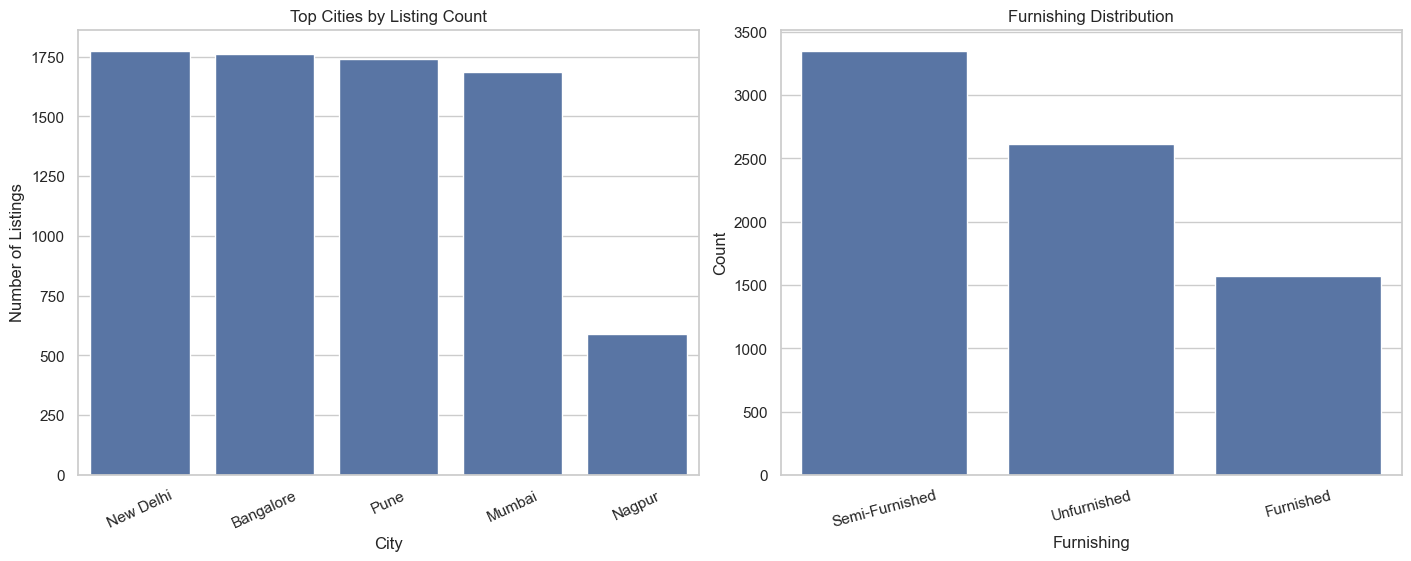

In [16]:
top_cities = (
    df["city"]
    .value_counts()
    .head(12)
    .reset_index()
)
top_cities.columns = ["city", "count"]

# Plot in a grid to reduce scrolling
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5), constrained_layout=True)

sns.barplot(
    data=top_cities,
    x="city",
    y="count",
    ax=axes[0]
)
axes[0].set_title("Top Cities by Listing Count")
axes[0].set_xlabel("City")
axes[0].set_ylabel("Number of Listings")
axes[0].tick_params(axis="x", rotation=25)

sns.countplot(
    data=df,
    x="furnishing",
    order=df["furnishing"].value_counts().index,
    ax=axes[1]
)
axes[1].set_title("Furnishing Distribution")
axes[1].set_xlabel("Furnishing")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis="x", rotation=15)

plt.show()


> **Notes**
> - If one city dominates, the model may become city-biased.
> - Later, check error by city.
> - Furnishing often shifts the rent baseline. This is a strong reason to keep it as a feature.

### 6.4 Rent by category (boxplots)

Boxplots show how rent spreads across categories.
We plot the top cities for readability.

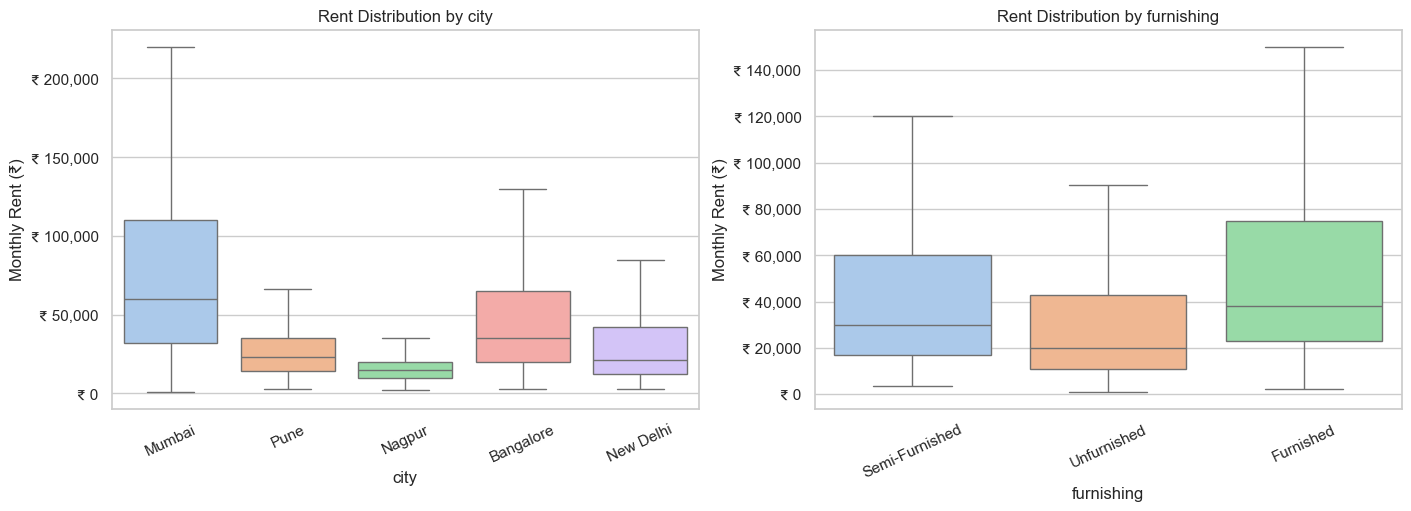

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_cols = ["city", "furnishing"]
categorical_cols = [c for c in categorical_cols if c in df.columns]

fig, axes = plt.subplots(1, len(categorical_cols), figsize=(14, 5), constrained_layout=True)

# Handle single-plot case
if len(categorical_cols) == 1:
    axes = [axes]

for ax, col in zip(axes, categorical_cols):
    sns.boxplot(
        data=df,
        x=col,
        y="rent",
        hue=col,
        palette="pastel",
        showfliers=False,
        legend=False,
        ax=ax
    )
    ax.yaxis.set_major_formatter(inr_formatter)
    ax.set_title(f"Rent Distribution by {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Monthly Rent (₹)")
    ax.tick_params(axis="x", rotation=25)

plt.show()


> **Note**
> - Some cities have a clearly higher rent range.
> - A global model needs to learn both city-level shifts and within-city trends.

## Key insights from EDA

Before we model, we write down a few observations from the charts.
This keeps the workflow realistic: **EDA should influence decisions**.

> **Notes**
> - Note the top cities. A model may learn dominant cities better than rare ones.
> - Compare median rent across furnishing levels. If the gaps are large, furnishing should help prediction.
> - Check which numeric feature correlates most with rent (often `area` or `area_rate`).

## 7) Correlation: Understanding Relationships Between Features

Correlation is a quick way to rank numeric relationships. 

**Correlation** measures how strongly two numeric variables move **together**.

* A **positive correlation** means both variables increase together
* A **negative correlation** means one increases while the other decreases
* A correlation close to **0** means little or no linear relationship

Correlation values typically range from **-1 to +1**.

### How Correlation Is Computed (Intuition)

For numeric features, correlation compares:

* how much each value deviates from its mean
* whether those deviations move in the same or opposite direction

In practice, we commonly use **Pearson correlation**, which captures **linear relationships** between variables.

### Why We Look at Correlation

Correlation helps us:

* understand which features are related to the target
* detect redundant or highly related features
* get an early sense of which variables may be useful for modeling

> Correlation does **not** imply causation — it’s an exploratory signal, not a conclusion.

### What We’ll Do Next

We will compute **correlation among numeric features**, including the target (`rent`), and visualize it to better understand their relationships.


In [18]:
# Correlation with rent (numeric only)
import pandas as pd
from IPython.display import display

corr = df[numeric_cols + ["rent"]].corr(numeric_only=True)

corr_with_rent = corr["rent"].drop("rent").sort_values(ascending=False).reset_index()
corr_with_rent.columns = ["feature", "correlation_with_rent"]

display(
    corr_with_rent.style
        .format({"correlation_with_rent": "{:.3f}"})
        .bar(subset=["correlation_with_rent"], align="mid")
        .set_caption("Numeric correlation with rent (higher magnitude → stronger linear relationship)")
)


,feature,correlation_with_rent
0,bathrooms,0.534
1,area_rate,0.507
2,beds,0.472
3,area,0.432
4,balconies,0.175


### 7.1 Correlation heatmap (numeric features)

A heatmap makes correlation patterns easier to scan.
We only include numeric columns here.

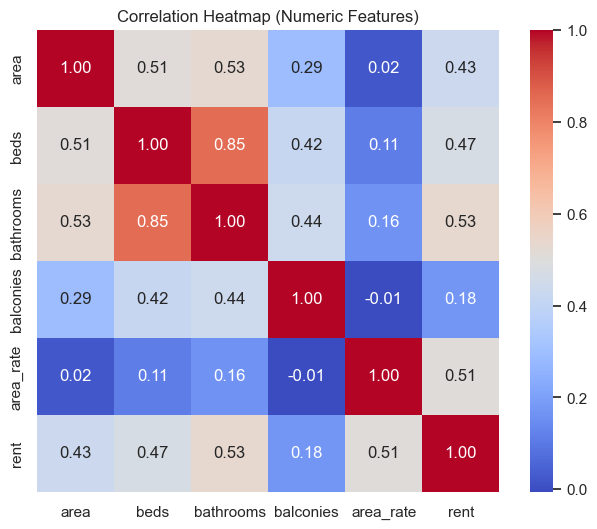

In [19]:
# A heatmap is a compact way to view correlations.
# We keep it to numeric columns to avoid mixing types.
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

## 8) Feature selection (baseline model)

We start with a small, stable set of features.

We use:
- numeric: `area`, `beds`, `bathrooms`, `balconies`, `area_rate`
- categorical: `city`, `furnishing`

We skip for now:
- `locality` (high-cardinality)
- `house_type` (free text)

Future idea:
- Use `locality` to map to a **pincode** or zone, then use grouped features.

In [20]:
num_features = ["area", "beds", "bathrooms", "balconies", "area_rate"]
cat_features = ["city", "furnishing"]

X_train_sel = X_train[num_features + cat_features].copy()
X_val_sel   = X_val[num_features + cat_features].copy()
X_test_sel  = X_test[num_features + cat_features].copy()

X_train_sel.head()

,area,beds,bathrooms,balconies,area_rate,city,furnishing
2663,2700.0,3.0,3.0,2.0,35.0,New Delhi,Unfurnished
1208,500.0,1.0,1.0,0.0,26.0,New Delhi,Semi-Furnished
1165,1431.0,2.0,2.0,0.0,70.0,Bangalore,Unfurnished
4583,810.0,2.0,2.0,2.0,10.0,Bangalore,Semi-Furnished
1098,150.0,2.0,2.0,0.0,133.0,New Delhi,Furnished


> **Notes**
> - Baselines should be simple and explainable.
> - You can add complexity later once you trust the pipeline.

## 9) Preprocessing with pipelines (imputation + one-hot)

A pipeline chains steps safely.
It also avoids data leakage.

Our preprocessor will:
- impute numeric missing values with the **mean**
- impute categorical missing values with the **most frequent**
- one-hot encode categorical columns

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features),
])

preprocess

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

### 9.1 One-hot encoding (how the data looks)

One-hot encoding turns each category into its own binary (0/1) column.  
This lets linear and tree-based models work with categorical inputs.

In [22]:
from IPython.display import display

# Show a tiny sample BEFORE encoding (raw categorical columns present)
sample_before = X_train_sel.head(3).copy()
display(sample_before)

# Fit the preprocessing on training data and show a small AFTER view
X_after = preprocess.fit_transform(X_train_sel)

# Build readable feature names (numeric + one-hot category names)
ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
ohe_feature_names = ohe.get_feature_names_out(cat_features)

feature_names = list(num_features) + list(ohe_feature_names)

# Convert a small slice to a DataFrame for display
sample_after = pd.DataFrame(X_after[:3], columns=feature_names)
display(sample_after)


,area,beds,bathrooms,balconies,area_rate,city,furnishing
2663,2700.0,3.0,3.0,2.0,35.0,New Delhi,Unfurnished
1208,500.0,1.0,1.0,0.0,26.0,New Delhi,Semi-Furnished
1165,1431.0,2.0,2.0,0.0,70.0,Bangalore,Unfurnished


,area,beds,bathrooms,balconies,area_rate,city_Bangalore,city_Mumbai,city_Nagpur,city_New Delhi,city_Pune,furnishing_Furnished,furnishing_Semi-Furnished,furnishing_Unfurnished
0,2700.0,3.0,3.0,2.0,35.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,500.0,1.0,1.0,0.0,26.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1431.0,2.0,2.0,0.0,70.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


> **Notes**
> - We do not clean the DataFrame by hand.
> - The pipeline learns imputation values from training data only.
> - `handle_unknown="ignore"` makes inference safer if a new city appears later.

## 10) Cross-validation (CV) for model comparison

Cross-validation trains the model multiple times on different folds of the training set.
This reduces the risk of a lucky or unlucky split.

We compare three models:

| Model                       | What is it?                                           | Key Idea                                                  | What it Optimizes                              | When It Works Well                                                 |
| --------------------------- | ----------------------------------------------------- | --------------------------------------------------------- | ---------------------------------------------- | ------------------------------------------------------------------ |
| **Linear Regression**       | Models the target as a weighted sum of input features | Assumes a linear relationship between features and target | Minimizes Mean Squared Error (MSE)             | When relationships are roughly linear and features are informative |
| **Ridge Regression**        | Linear Regression with coefficient regularization     | Penalizes large coefficients to reduce overfitting        | MSE + L2 penalty on coefficients               | When features are correlated or feature space is high-dimensional  |
| **Decision Tree Regressor** | Learns a set of if–else rules to make predictions     | Recursively splits data to reduce prediction error        | Reduces variance (squared error) at each split | When relationships are non-linear or feature interactions matter   |



### 📏 Regression Evaluation Metrics

| Metric                        | What It Measures                                                  | Interpretation                                  |
| ----------------------------- | ----------------------------------------------------------------- | ----------------------------------------------- |
| **MAE** (Mean Absolute Error) | Average absolute difference between predictions and actual values | Easy to interpret, same units as the target (₹) |
| **MSE** (Mean Squared Error)  | Average of squared prediction errors                              | Penalizes large errors more heavily             |
| **R²** (R-squared)            | How much of the variation in the target is explained by the model | Closer to 1 means better explanatory power      |


### Quick Notes

* **MAE** → “On average, how wrong are we?”
* **MSE** → “How bad are large mistakes?”
* **R²** → “How well does the model explain the data?”

> Always look at **error metrics (MAE/MSE)** along with **R²**.

If you want an even tighter 2-row version or a spoken-script version, I can do that too.


In [23]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
import numpy as np

### Cross-Validation (Why We Use It)

Cross-validation helps us **estimate how well a model will perform on unseen data**.

Instead of training and evaluating the model on a single split:

* the data is split into multiple folds
* the model is trained and evaluated multiple times
* results are averaged for a more reliable estimate

This reduces the risk of:

* depending too much on one lucky (or unlucky) split
* overestimating model performance

> Cross-validation gives a **more stable and trustworthy evaluation**.


In [24]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

candidates = {
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
}

def cv_mae_scores(model, X, y):
    from sklearn.pipeline import Pipeline
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_absolute_error")
    return -scores  # convert to positive MAE

cv_scores = {name: cv_mae_scores(model, X_train_sel, y_train) for name, model in candidates.items()}

cv_scores_df = pd.DataFrame(cv_scores)
summary = pd.DataFrame(
    {
        "MAE (mean)": cv_scores_df.mean().astype(float),
        "MAE (std)": cv_scores_df.std(ddof=0).astype(float),
    }
).sort_values("MAE (mean)")

display(cv_scores_df.style.format(precision=2))
display(summary.style.format(precision=3))


,LinearRegression,Ridge(alpha=1.0),DecisionTree
0,28252.06,28241.86,4473.23
1,27136.60,27124.91,7329.08
2,30252.79,30243.75,9213.49
3,28263.12,28251.42,6171.54
4,30695.25,30683.55,6107.20


,MAE (mean),MAE (std)
DecisionTree,6658.910,1568.064
Ridge(alpha=1.0),28909.099,1340.973
LinearRegression,28919.965,1340.596


> **Notes**
> - You see fold-by-fold RMSE for each model.
> - Lower MAE is better.
> - High spread across folds means instability.

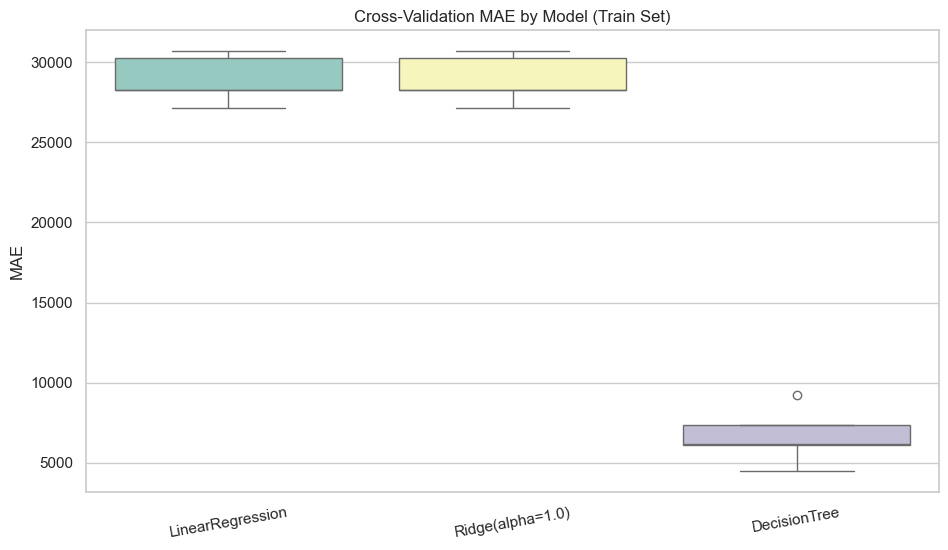

In [25]:
# Visualize CV score distributions (long-form)
cv_long = cv_scores_df.melt(var_name="model", value_name="mae")

plt.figure(figsize=(11, 6))
ax = sns.boxplot(data=cv_long, x="model", y="mae", hue="model", palette="Set3")
if ax.get_legend() is not None:
    ax.get_legend().remove()

plt.title("Cross-Validation MAE by Model (Train Set)")
plt.ylabel("MAE")
plt.xlabel("")
plt.xticks(rotation=10)
plt.show()


> **Notes**
> - Prefer models with low mean RMSE and low variance.
> - Trees can overfit and show higher variance.

## 11) Train each model and evaluate on the validation set

Now we train on the training split once.
Then we score on the validation split.
This is a realistic model-selection loop.

In [26]:
from sklearn.metrics import mean_absolute_error, r2_score

def train_and_eval(model, X_tr, y_tr, X_eval, y_eval):
    from sklearn.pipeline import Pipeline
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    pipe.fit(X_tr, y_tr)
    preds = pipe.predict(X_eval)
    mae = float(mean_absolute_error(y_eval, preds))
    r2 = float(r2_score(y_eval, preds))
    return pipe, preds, mae, r2

val_results = []
val_preds = {}
trained = {}

for name, model in candidates.items():
    pipe, preds, mae, r2 = train_and_eval(model, X_train_sel, y_train, X_val_sel, y_val)
    trained[name] = pipe
    val_preds[name] = preds
    val_results.append((name, mae, r2))

val_table = pd.DataFrame(val_results, columns=["model", "val_MAE", "val_R2"]).sort_values("val_MAE")
display(val_table.style.format({"val_MAE": "{:.2f}", "val_R2": "{:.3f}"}))


,model,val_MAE,val_R2
2,DecisionTree,6593.25,0.852
1,Ridge(alpha=1.0),30522.17,0.321
0,LinearRegression,30530.30,0.321


> **Notes**
> - Validation MAE is easiest to interpret in ₹.
> - R² is a sanity check. Do not optimize for it blindly.

### 11.1 Validation residuals (per model)

Residual = actual − predicted.
We want residuals centered around 0 with reasonable spread.

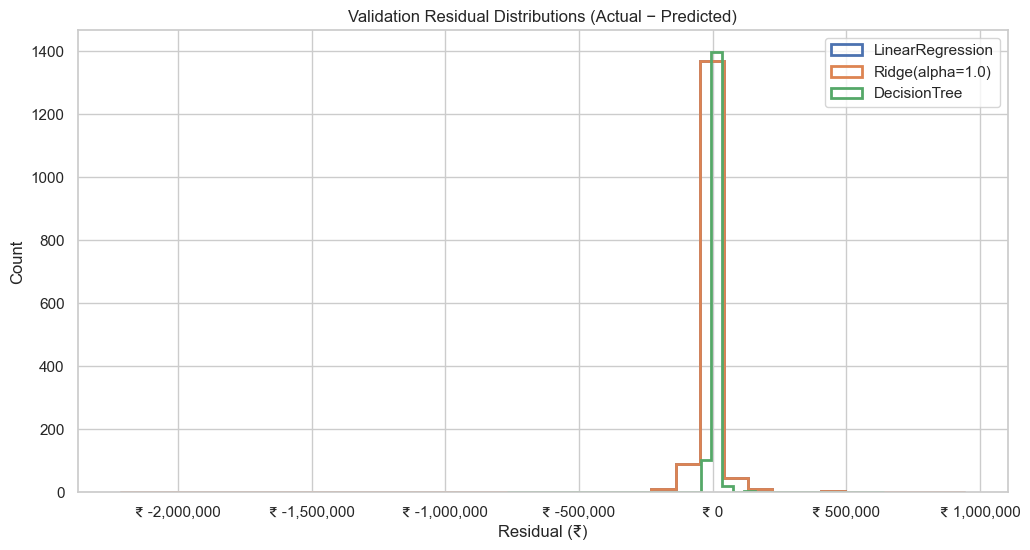

In [27]:
plt.figure(figsize=(12, 6))
for name, preds in val_preds.items():
    if (name == 'LinearRegression') or (name == 'DecisionTree') or (name == 'Ridge(alpha=1.0)'):
        residuals = y_val.values - preds
        plt.hist(residuals, bins=35, histtype="step", linewidth=2, label=name)

plt.gca().xaxis.set_major_formatter(inr_formatter)
plt.title("Validation Residual Distributions (Actual − Predicted)")
plt.xlabel("Residual (₹)")
plt.ylabel("Count")
plt.legend()
plt.show()


> **Note**
> - Narrower residual distributions usually mean lower error.
> - Long tails usually come from premium listings and outliers.

## 12) Pick the best model and evaluate on the test set

We pick the model with the best validation RMSE.
Then we refit it on train + validation.
Finally, we evaluate once on the test set.

In [28]:
best_name, best_mae, best_r2 = val_table.iloc[0]["model"], float(val_table.iloc[0]["val_MAE"]), float(val_table.iloc[0]["val_R2"])

best_summary = pd.DataFrame(
    [{"best_model": best_name, "best_val_MAE": best_mae, "best_val_R2": best_r2}]
)
display(best_summary.style.format({"best_val_MAE": "{:.2f}", "best_val_R2": "{:.3f}"}))


,best_model,best_val_MAE,best_val_R2
0,DecisionTree,6593.25,0.852


> **Notes**
> - After this point, we stop comparing models.
> - The test set is used only once.

In [29]:
best_model = candidates[best_name]

X_trainval_sel = X_trainval[num_features + cat_features].copy()

from sklearn.pipeline import Pipeline
final_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", best_model)])
final_pipe.fit(X_trainval_sel, y_trainval)

test_preds = final_pipe.predict(X_test_sel)

test_mae = float(mean_absolute_error(y_test, test_preds))
test_r2 = float(r2_score(y_test, test_preds))

test_summary = pd.DataFrame(
    [{"model": best_name, "test_MAE": test_mae, "test_R2": test_r2}]
)
display(test_summary.style.format({"test_MAE": "{:.2f}", "test_R2": "{:.3f}"}))


,model,test_MAE,test_R2
0,DecisionTree,5455.91,0.785


> **Note**
> - This test RMSE is your final unbiased estimate.
> - Do not tune hyperparameters using the test set.

## 13) Error analysis on the test set

We inspect:
- residual distribution
- biggest mistakes (largest absolute error)
- average error by city (quick check)

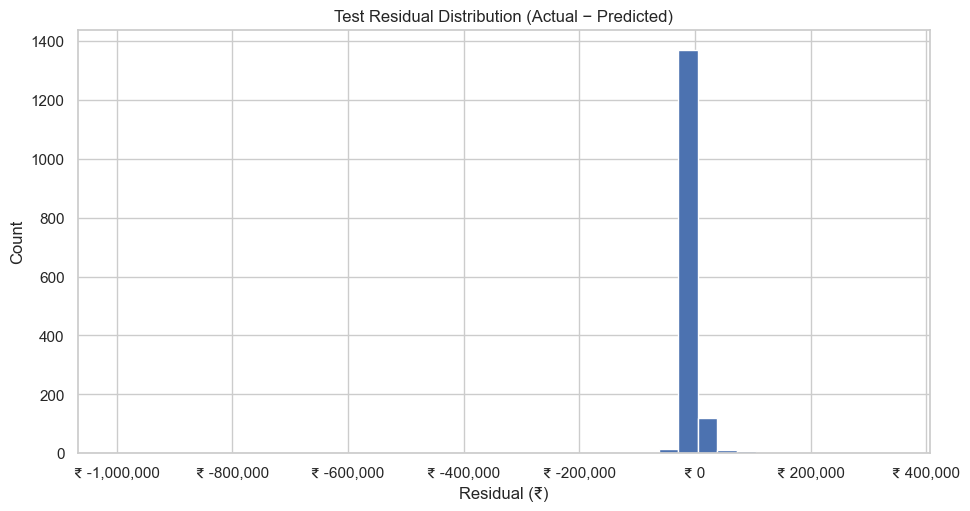

In [30]:
test_residuals = y_test.values - test_preds

plt.figure(figsize=(11, 5.5))
plt.hist(test_residuals, bins=40)
plt.gca().xaxis.set_major_formatter(inr_formatter)
plt.title("Test Residual Distribution (Actual − Predicted)")
plt.xlabel("Residual (₹)")
plt.ylabel("Count")
plt.show()


> **Notes**
> - If residuals are shifted left or right, the model is biased.
> - Wide spread means the model is not precise.
> - Long tails indicate outliers.

In [31]:
# Biggest errors (top 15)
from IPython.display import display
import pandas as pd
import numpy as np

# Reconstruct the error table explicitly (safe if cells are run out of order)
errors = X_test_sel.copy()
errors["actual_rent"] = y_test.values
errors["predicted_rent"] = test_preds
errors["abs_error"] = np.abs(errors["actual_rent"] - errors["predicted_rent"])

top_err = errors.sort_values("abs_error", ascending=False).head(15).copy()

display(
    top_err.style
        .format({
            "actual_rent": "₹ {:,.0f}",
            "predicted_rent": "₹ {:,.0f}",
            "abs_error": "₹ {:,.0f}",
        })
        .bar(subset=["abs_error"], align="mid")
        .set_caption("Largest absolute errors on the test set")
)


,area,beds,bathrooms,balconies,area_rate,city,furnishing,actual_rent,predicted_rent,abs_error
3135,760.000000,2.000000,3.000000,3.000000,658.000000,Mumbai,Unfurnished,"₹ 500,000","₹ 1,500,000","₹ 1,000,000"
3049,2100.000000,4.000000,5.000000,0.000000,nan,Mumbai,Semi-Furnished,"₹ 400,000","₹ 60,000","₹ 340,000"
4081,70000.000000,4.000000,5.000000,3.000000,6.000000,Bangalore,Semi-Furnished,"₹ 450,000","₹ 150,000","₹ 300,000"
2921,nan,3.000000,3.000000,4.000000,39.000000,Bangalore,Furnished,"₹ 350,000","₹ 60,000","₹ 290,000"
4824,3200.000000,3.000000,3.000000,0.000000,38.000000,Bangalore,nan,"₹ 120,000","₹ 400,000","₹ 280,000"
473,3000.000000,3.000000,3.000000,0.000000,40.000000,Bangalore,Semi-Furnished,"₹ 120,000","₹ 400,000","₹ 280,000"
2996,2920.000000,3.000000,3.000000,3.000000,43.000000,Bangalore,Semi-Furnished,"₹ 130,000","₹ 330,000","₹ 200,000"
7249,3000.000000,3.000000,3.000000,3.000000,48.000000,Bangalore,Furnished,"₹ 150,000","₹ 330,000","₹ 180,000"
1372,3800.000000,4.000000,3.000000,3.000000,46.000000,Bangalore,Furnished,"₹ 180,000","₹ 330,000","₹ 150,000"
6934,5200.000000,5.000000,5.000000,0.000000,82.000000,Pune,Furnished,"₹ 430,000","₹ 300,000","₹ 130,000"


> **Notes**
> - This table is actionable.
> - It shows which listings need better features or a stronger model.

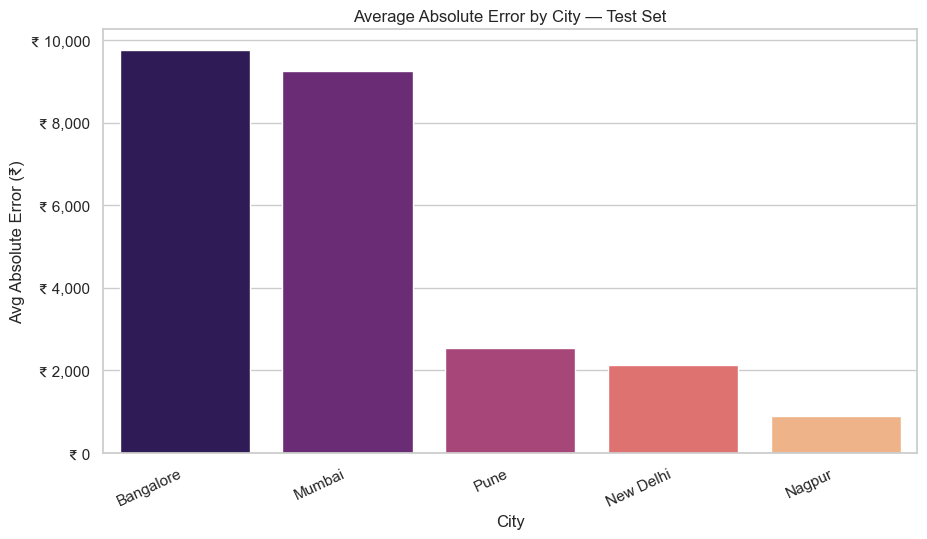

,city,avg_abs_error
0,Bangalore,"₹ 9,767"
1,Mumbai,"₹ 9,248"
2,Pune,"₹ 2,544"
3,New Delhi,"₹ 2,122"
4,Nagpur,₹ 894


In [32]:
if "city" in errors.columns:
    city_mae = (
        errors.groupby("city")["abs_error"]
        .mean()
        .sort_values(ascending=False)
    )

    plt.figure(figsize=(10.5, 5.5))
    sns.barplot(
        x=city_mae.index[:10],
        y=city_mae.values[:10],
        hue=city_mae.index[:10],   # explicitly map color
        palette="magma",
        legend=False               # avoid redundant legend
    )
    plt.gca().yaxis.set_major_formatter(inr_formatter)
    plt.title("Average Absolute Error by City — Test Set")
    plt.xlabel("City")
    plt.ylabel("Avg Absolute Error (₹)")
    plt.xticks(rotation=25, ha="right")
    plt.show()

    city_mae.head(10)

# Also show the table for quick reading
from IPython.display import display
import pandas as pd

city_mae_table = city_mae.head(10).reset_index()
city_mae_table.columns = ["city", "avg_abs_error"]

display(
    city_mae_table.style
        .format({"avg_abs_error": "₹ {:,.0f}"})
        .bar(subset=["avg_abs_error"], align="mid")
        .set_caption("Avg absolute error by city (top 10) — test set")
)


> **Note**
> - If one city has much higher error, you may need more data or better features for that city.
> - This is a common production issue for geo-based models.

## 14) Recap and next steps

We built a realistic ML workflow:
- EDA with readable plots
- explicit missing data handling section
- train / validation / test split
- preprocessing pipeline (impute + one-hot)
- model comparison using cross-validation
- final evaluation on the test set
- error analysis

**Next steps**
- Try stronger models (RandomForest, GradientBoosting)
- Engineer features (log(rent), rent per sqft)
- Add locality carefully (high-cardinality strategies)
- Map locality to zones/pincodes for richer location signals

## Saving the Best Model (Deployment Prep)

Training a model is only half the job — **deployment is where most real work happens**.
Typically you must ensure:
- the **same preprocessing** runs in production
- requests are handled with **reliability and low latency**
- the system supports **monitoring, drift detection, and retraining**
- the service is **versioned, tested, and scalable** (MLOps)

Next, we’ll save the **full pipeline (preprocess + model)** so it can be loaded directly in a FastAPI service.


In [33]:
from sklearn.pipeline import Pipeline
import joblib
from pathlib import Path
from datetime import datetime

# 1) Choose the best model (set this based on your selection)
# Example:
# best_model = Ridge(alpha=1.0)
# best_model = DecisionTreeRegressor(max_depth=6, random_state=42)

# 2) Build the full pipeline (preprocess + model)
best_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", best_model),
])

# 3) Fit on training data (or train+val if you decide later)
best_pipeline.fit(X_train_sel, y_train)

# 4) Save to disk
artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = artifacts_dir / f"rent_model_pipeline_{timestamp}.joblib"

joblib.dump(best_pipeline, model_path)

print(f"✅ Saved model pipeline to: {model_path}")
print("Includes preprocessing + model (ready to load in FastAPI).")


✅ Saved model pipeline to: artifacts\rent_model_pipeline_20260203_124158.joblib
Includes preprocessing + model (ready to load in FastAPI).


### Quick “load and predict”

In [34]:
loaded = joblib.load(model_path)
sample_preds = loaded.predict(X_train_sel.head(3))
print(sample_preds)


[ 95000.  13000. 100000.]


## 🧠 Optional: Interpreting the Decision Tree Model

At this point, we have a trained pipeline that includes both:
- preprocessing (imputation + one-hot encoding)
- the final Decision Tree model

In this optional section, we inspect **feature importance** to understand:
- which inputs have the biggest impact on predictions
- why changing some inputs (e.g., `city`) may not change the predicted rent

Note: With one-hot encoding, a single categorical feature (like `city`) becomes many binary columns.
So we will look at importance in two ways:
1. top transformed features (after preprocessing)
2. importance aggregated back to the original feature names


Top 15 transformed features used by the tree:


,feature,importance
4,num__area_rate,0.451211
0,num__area,0.406667
2,num__bathrooms,0.102433
1,num__beds,0.016926
8,cat__city_New Delhi,0.015339
10,cat__furnishing_Furnished,0.004585
5,cat__city_Bangalore,0.001555
3,num__balconies,0.000492
6,cat__city_Mumbai,0.000327
11,cat__furnishing_Semi-Furnished,0.000238


Total importance by original feature:


,total_importance
base_feature,
area_rate,0.451211
area,0.406667
bathrooms,0.102433
city,0.017314
beds,0.016926
furnishing,0.004957
balconies,0.000492


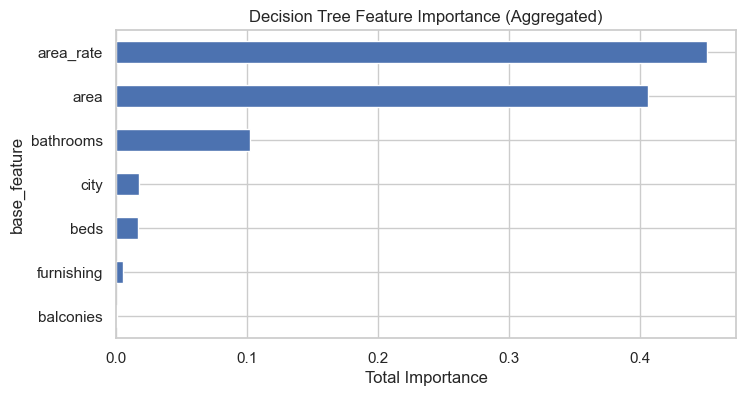

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Extract fitted preprocessing + trained tree from your pipeline ---
preprocess_fitted = best_pipeline.named_steps["preprocess"]
tree = best_pipeline.named_steps["model"]

# --- Get feature names after preprocessing and importance scores ---
feature_names = preprocess_fitted.get_feature_names_out()
importances = tree.feature_importances_

feature_importance_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

print("Top 15 transformed features used by the tree:")
display(feature_importance_df.head(15))

# --- Correctly map transformed feature names back to original features ---
# Remove "num__" / "cat__" prefix
clean = feature_importance_df["feature"].str.replace(r"^(num__|cat__)", "", regex=True)

def base_feature_name(transformed_name: str, cat_cols) -> str:
    """
    Map names like:
      - city_Bangalore -> city
      - furnishing_Fully Furnished -> furnishing
      - area_rate -> area_rate  (do NOT split numeric names with underscores)
    """
    for c in cat_cols:
        if transformed_name == c or transformed_name.startswith(c + "_"):
            return c
    return transformed_name

# cat_features should already exist in your notebook; if not, define it consistently
# cat_features = ["city", "furnishing"]  # example
feature_importance_df["base_feature"] = clean.apply(lambda s: base_feature_name(s, cat_features))

# --- Aggregate importance back to original feature level ---
grouped_importance = (
    feature_importance_df.groupby("base_feature")["importance"]
    .sum()
    .sort_values(ascending=False)
)

print("Total importance by original feature:")
display(grouped_importance.to_frame("total_importance"))

# --- Plot top 10 original features ---
top_k = 10
grouped_importance.head(top_k).sort_values().plot(kind="barh", figsize=(8, 4))
plt.title("Decision Tree Feature Importance (Aggregated)")
plt.xlabel("Total Importance")
plt.show()


### 🎯 Key Takeaway

> Feature importance tells us what the **model learned**,
> not what we **assumed** would be important.

This step helps us:

* trust the model
* explain predictions
* identify missing or redundant features
